In [69]:
import numpy as np
from enum import Enum
from copy import copy, deepcopy
from collections import deque

import matplotlib.pyplot as plt 
%matplotlib notebook

from scipy.ndimage.filters import uniform_filter1d


In [101]:
CALORIES_STEP_SIZE=250

class Goal(Enum):
    LOSS = -CALORIES_STEP_SIZE
    MAINTAIN = 0
    GAIN = CALORIES_STEP_SIZE

In [102]:
class UnhandledCaseException(Exception):
    pass

In [103]:
objective = Goal.LOSS

In [104]:
objective.name

'LOSS'

In [105]:
objective.value

-250

In [106]:
aca = 2000

In [107]:
dej = 1900

In [108]:
mb = 1400

In [109]:
assert dej > mb 

In [110]:
def is_close(a, b, close=150):
    if abs(a - b) < close:
        return True
    return False

In [111]:
def init():

    if objective.name == 'LOSS':

        if aca > dej:
            print("Generate a menu equal to (or less than) ACA")
        elif is_close(aca, dej):
                print("Generate a menu equal to (or less than) ACA")
        elif aca < dej:
                print("Generate a menu equal to (or less than) ACA")
        else: 
            raise UnhandledCaseException()


    if objective.name == 'MAINTAIN':
        raise UnhandledCaseException()


    if objective.name == 'GAIN':
        if aca > dej:
            print("Generate a menu equal to (or less than) ACA")
        elif is_close(aca, dej):
                print("Generate a menu equal to (or less than) ACA")
        elif aca < dej:
                print("Generate a menu equal to (or less than) ACA")
        else: 
            raise UnhandledCaseException()

In [117]:
class State:
    pass

class Sequence:
    def __init__(self):
        self.state = {
            "goal": objective,
            "age_in_weeks": 0,
            "phase": Phase.LOSS,
            "dej": dej,
            "mb": mb,
            "aca": aca,
            "weight": 80,
            "weeks_in_phase": 0,
        }
        self.history = deque(maxlen=10)
        
    def get_weight_last_n_weeks(self, n=3):
        if len(self.history) >= n:
            return [x["weight"] for x in self.history][-n:]

In [118]:
s = Sequence()
s.state

{'goal': <Goal.LOSS: -250>,
 'age_in_weeks': 0,
 'phase': <Phase.LOSS: 0>,
 'dej': 1900,
 'mb': 1400,
 'aca': 2000,
 'weight': 80,
 'weeks_in_phase': 0}

In [119]:
s.get_weight_last_n_weeks()

In [158]:
for i in range(12):
    if s.state["age_in_weeks"] == 0:
        init()
        s.state["age_in_weeks"] += 1
    else: 
        print(s.state)
        _state = deepcopy(s.state)
        
        ## update state
        h = s.get_weight_last_n_weeks()
        if len(h) >= 3:
            delta = h[-1] - h[0]
            if delta >= 0: # prise de poids ou stagnation
                s.state["aca"] -= 250 # todo check if aca > mb, should not go below mb
        ## end update state
        
        s.history.append(_state)
        s.state["age_in_weeks"] += 1
        s.state["weeks_in_phase"] += 1
    

{'goal': <Goal.LOSS: -250>, 'age_in_weeks': 1, 'phase': <Phase.LOSS: 0>, 'dej': 1900, 'mb': 1400, 'aca': 2000, 'weight': 80, 'weeks_in_phase': 0}


TypeError: object of type 'NoneType' has no len()

In [111]:
h = s.get_weight_last_n_weeks()
delta = h[-1] - h[0]
delta

0

# Separer l'objectif de la phase

In [206]:
class Phase(Enum):
    LOSS = 0
    STOP = 1
    MAINTAINANCE = 2 
    GAIN = 3

In [115]:
# Cycler p127

In [116]:
if objective.name == 'LOSS':
    print("PERTE")
    print("ARRET")
    print("ENTRETIEN")
    print("PERTE")
    
if objective.name == 'GAIN':
    print("GAIN")
    print("ARRET")
    print("ENTRETIEN")
    print("GAIN")

PERTE
ARRET
ENTRETIEN
PERTE


# Simulation 

In [289]:
def next_weight(aca, dej, sigma=0.7):
    return np.random.normal(0, sigma) + ((aca - dej) * 7) / 7000 

In [335]:
initial_weight = 80

n_weeks = 100

delta_w = np.random.normal(size=100)

weights = np.cumsum(delta_w)
height = 1.80
age = 30

dej_hat = compute_dej(initial_weight, height, age)
aca = dej_hat



In [336]:
def compute_dej(weight, height, age):
    return 1.8 * 191 * (1.083 * weight**0.48) * (height**0.50) * (age**-0.13)

## Build muscle

In [337]:
def gain(x):
    if x > 0.5: 
        return 0
    if x <= 0.5:
        return CALORIES_STEP_SIZE

def maintain(x):
    if x > -0.5 and x < 0.5: 
        return 0
    if x > 0.5:
        return -CALORIES_STEP_SIZE
    if x < 0.5:
        return CALORIES_STEP_SIZE

In [343]:
weight_history = []
aca_history = []

weight_history.append(initial_weight)
aca_history.append(aca)
phases_history = [Phase.GAIN]

for i in range(n_weeks):
    delta_w = next_weight(aca, dej_hat)
    delta_cal = 0
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    
    
    current_phase = phases_history[-1]
    duration = 1
    for i in range(0, len(phases_history)):
        if phases_history[-i-1] == current_phase:
            duration += 1
        else:
            break
            
    #print(duration)
    
    if current_phase == Phase.GAIN and duration <= 16:
        new_phase = Phase.GAIN
        
    
    if current_phase == Phase.GAIN and duration > 16:
        new_phase = Phase.STOP
        duration = 1
        
    if current_phase == Phase.STOP:
        if is_close(dej_hat, aca, close=200):
            new_phase = Phase.MAINTAINANCE
            phases_history.append(new_phase)
         
    if new_phase == Phase.MAINTAINANCE:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = maintain(y[-1])
    
    if new_phase == Phase.GAIN:
        if len(weight_history) > 3:
            weight_derivative = np.gradient(weight_history)
            y = uniform_filter1d(weight_derivative, size=3)
            delta_cal = gain(y[-1])
    
    if new_phase == Phase.STOP:
        if duration == 1:
            dej_hat = compute_dej(weight_history[-1], height, age)
        #print(dej_hat)
        if not is_close(dej_hat, aca, close=200):
            delta_cal = -CALORIES_STEP_SIZE
    
    phases_history.append(new_phase)
    aca = aca + delta_cal
    aca_history.append(aca)
    
#    print(aca)

<IPython.core.display.Javascript object>


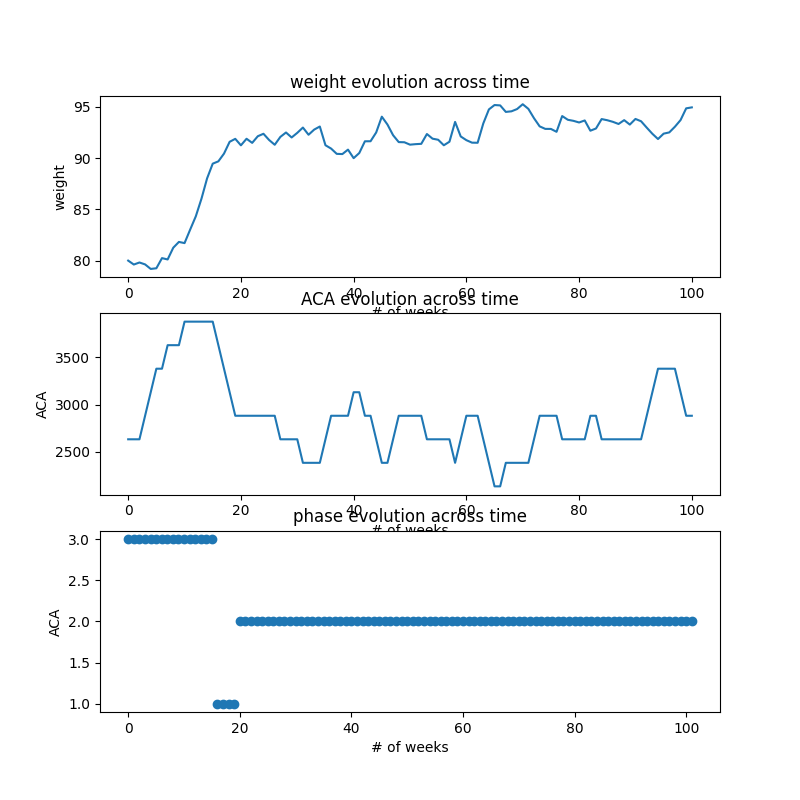

In [344]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(311)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(312)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

ax3 = fig.add_subplot(313)
ax3.set_ylabel('ACA')
ax3.set_xlabel('# of weeks')
ax3.set_title('phase evolution across time')
ax3.scatter(range(len(phases_history)), [x.value for x in phases_history]) 

plt.show()

## Lose Fat

In [203]:
def loss(x):
    if x < -0.5: 
        return 0
    if x > -0.5:
        return -CALORIES_STEP_SIZE

In [204]:
weight_history = []
aca_history = []

weight_history.append(initial_weight)
aca_history.append(aca)

for i in range(n_weeks):
    delta_w = next_weight(aca, dej_hat)
    delta_cal = 0
    
    if len(weight_history) > 3:
        weight_derivative = np.gradient(weight_history)
        y = uniform_filter1d(weight_derivative, size=3)
        delta_cal = loss(y[-1])
        
    
    new_weight = weight_history[-1] + delta_w
    weight_history.append(new_weight)
    aca = aca + delta_cal
    aca_history.append(aca)

    
#    print(aca)

<IPython.core.display.Javascript object>


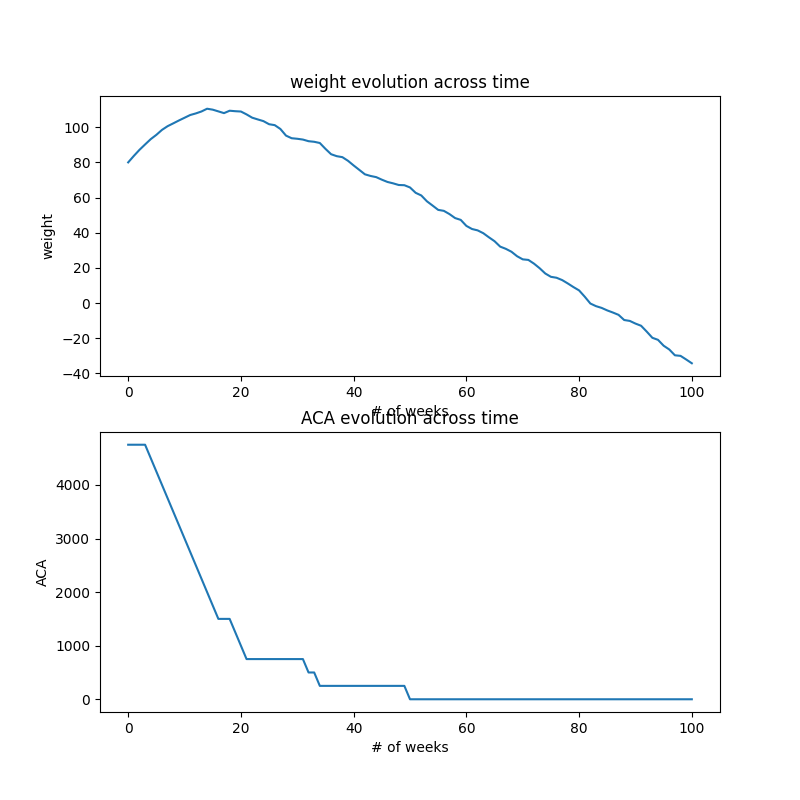

In [205]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(211)
ax1.set_ylabel('weight')
ax1.set_xlabel('# of weeks')
ax1.set_title('weight evolution across time')
ax1.plot(weight_history)


ax2 = fig.add_subplot(212)
ax2.set_ylabel('ACA')
ax2.set_xlabel('# of weeks')
ax2.set_title('ACA evolution across time')
ax2.plot(aca_history)

plt.show()

<IPython.core.display.Javascript object>


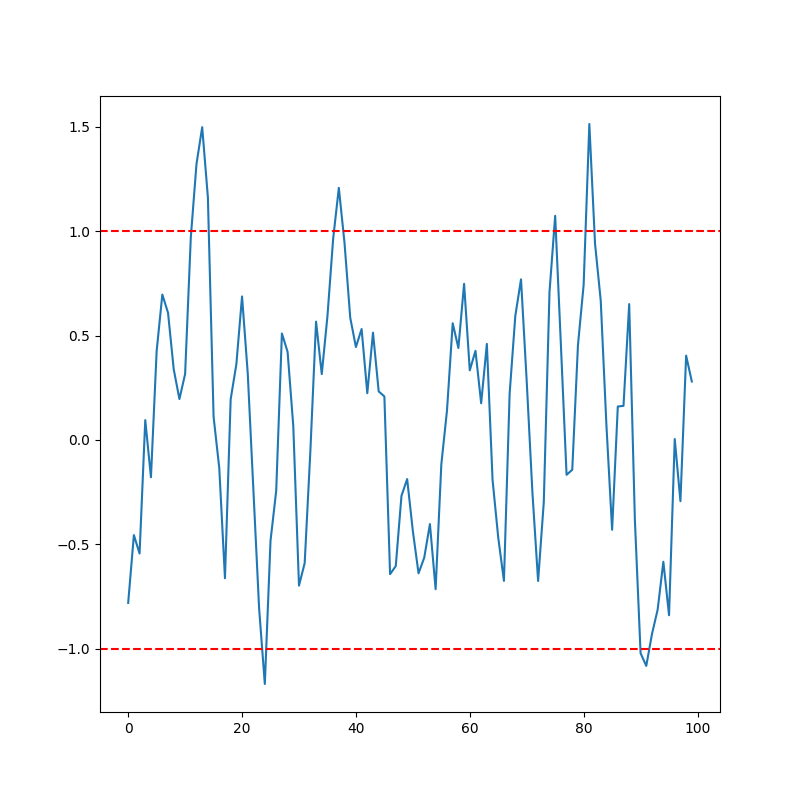

In [152]:
plt.figure(figsize=(8,8))

plt.plot(y)

plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=-1, color='r', linestyle='--')

plt.show()


<IPython.core.display.Javascript object>


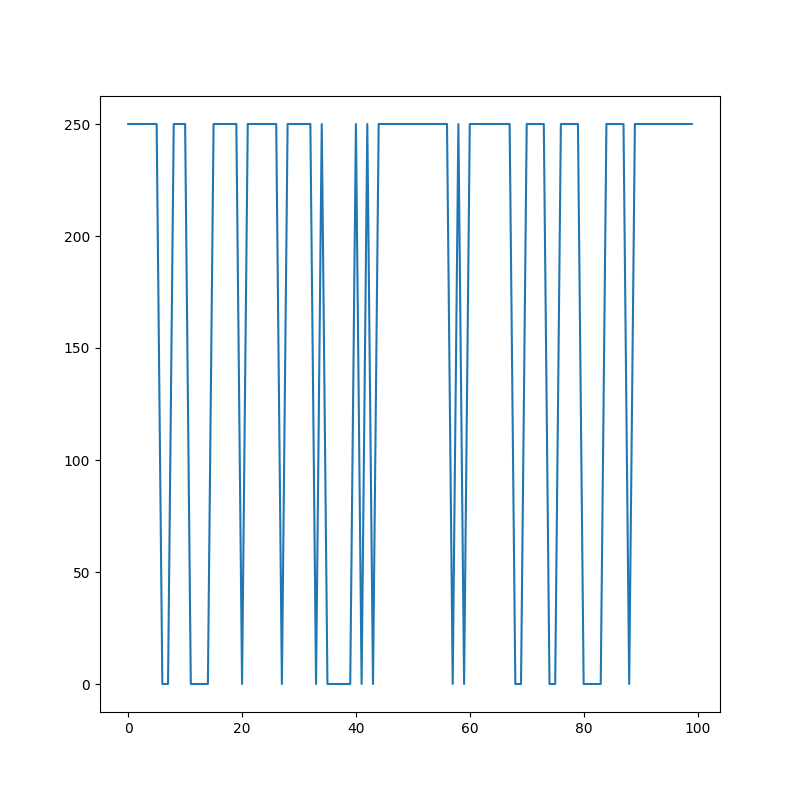

In [154]:
def gain(x):
    if x > 0.5: 
        return 0
    if x < 0.5:
        return CALORIES_STEP_SIZE

plt.figure(figsize=(8,8))

gain_vec = np.vectorize(gain)
delta_calories_gain = gain_vec(y)

plt.plot(delta_calories_gain)

plt.show()


<IPython.core.display.Javascript object>


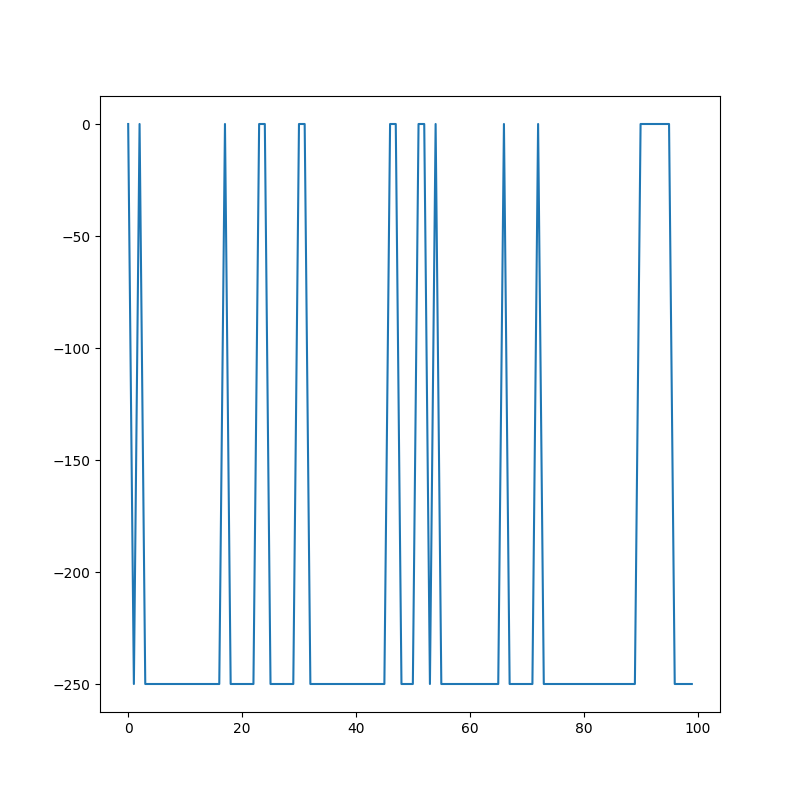

In [155]:
def loss(x):
    if x < -0.5: 
        return 0
    if x > -0.5:
        return -CALORIES_STEP_SIZE

plt.figure(figsize=(8,8))

loss_vec = np.vectorize(loss)
delta_calories_loss = loss_vec(y)

plt.plot(delta_calories_loss)

plt.show()


<IPython.core.display.Javascript object>


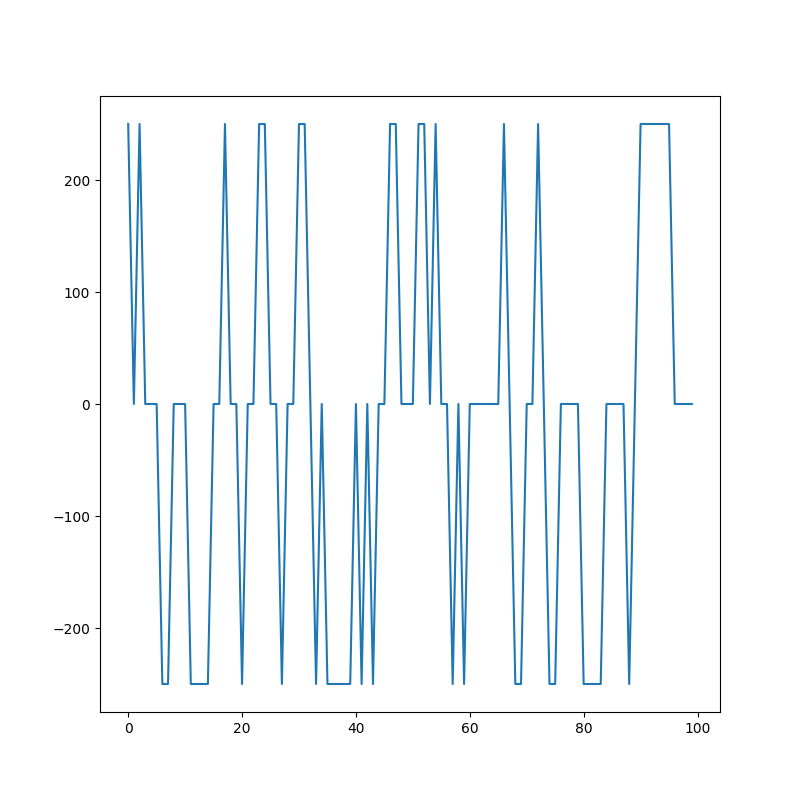

In [157]:
def maintain(x):
    if x > -0.5 and x < 0.5: 
        return 0
    if x > 0.5:
        return -CALORIES_STEP_SIZE
    if x < 0.5:
        return CALORIES_STEP_SIZE

plt.figure(figsize=(8,8))

maintain_vec = np.vectorize(maintain)
delta_calories_maintain = maintain_vec(y)

plt.plot(delta_calories_maintain)

plt.show()
